# Installation and dependencies

In [2]:
%pip install tensorflow==2.14.1 opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Standard dependencies
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import shutil
import time

In [51]:
# Tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# Creating data directories

In [5]:
# Setting up dirs
POS_DIR = os.path.join("data", "positive")
NEG_DIR = os.path.join("data", "negative")
ANC_DIR = os.path.join("data", "anchor")

# Checking if the folders exist
POS_DIR_isExist = os.path.exists(POS_DIR)
NEG_DIR_isExist = os.path.exists(NEG_DIR)
ANC_DIR_isExist = os.path.exists(POS_DIR)

# Creating dirs
os.makedirs(POS_DIR) if not POS_DIR_isExist else None
os.makedirs(NEG_DIR) if not NEG_DIR_isExist else None
os.makedirs(ANC_DIR) if not ANC_DIR_isExist else None

# Data collection

## Collecting positive examples

In [6]:
'''
    Dataset:
    https://www.kaggle.com/datasets/jessicali9530/lfw-dataset?resource=download
'''

# Unzipping kaggle data
with ZipFile("archive.zip", "r") as zip_object:
    zip_object.extractall()

# Replace old paths with new paths
lfw = "lfw-deepfunneled/lfw-deepfunneled/"

# Move the images to negative example
for dir in os.listdir(lfw):
    for file in os.listdir(os.path.join(lfw, dir)):
        OLD_PATH = os.path.join(lfw, dir, file)
        NEW_PATH = os.path.join(NEG_DIR, file)
        os.replace(OLD_PATH, NEW_PATH)

# Remove now empty directory
shutil.rmtree("lfw-deepfunneled")

# Set up webcam for postive and anchor collection

In [7]:
# Function for cutting the frame to match image data
def center_crop(img, dim):
    width, height  = img.shape[1], img.shape[0]

    crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0]

    mid_x, mid_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2) 

    crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2, :]

    return crop_img

In [8]:
# Import uuid library
import uuid
# uuid.uuid1()

In [9]:
# Constructing camera object
deviceID = 0 # 0-webcam, 1-laptop
cap = cv2.VideoCapture(deviceID)

# Error handling when opening the camera is not available
if not cap.isOpened():
    exit()

while cap.isOpened():
    # Capture return value and frame
    ret, frame = cap.read()

    # Error handling if no return value
    if not ret:
        break

    # Reduced the frame
    size = (250, 250)
    frame = center_crop(frame, size)

    # Collect anchors
    if cv2.waitKey(1) & 0xFF == ord("a"):
        imgname = os.path.join(ANC_DIR, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord("p"):
        imgname = os.path.join(POS_DIR, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    # Show the frame
    cv2.imshow("Webcam frame", frame)
    # Creating quit key
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release the capture and destroy frames
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

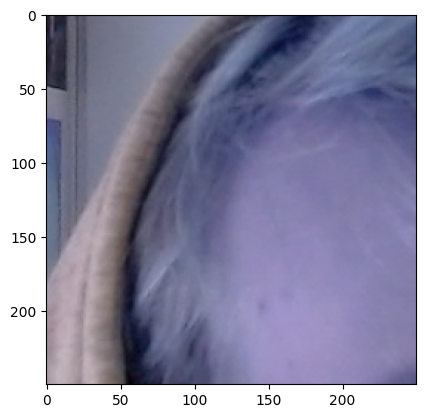

In [10]:
plt.imshow(frame)

# Dataloader and preprocessing

In [11]:
anchor = tf.data.Dataset.list_files(ANC_DIR + "/*.jpg").take(300)
positive = tf.data.Dataset.list_files(POS_DIR + "/*.jpg").take(300)
negative = tf.data.Dataset.list_files(NEG_DIR + "/*.jpg").take(300)

In [12]:
dir_test = anchor.as_numpy_iterator()

In [13]:
print(dir_test.next())

b'data/anchor/31109cea-c108-11ee-bd9f-9a60f45df4af.jpg'


In [14]:
# Image preprocessing
def preprocess(path):
    # Read in image
    byte_img = tf.io.read_file(path)
    # Decode jpeg
    img = tf.io.decode_jpeg(byte_img)
    # Resizing image 
    img = tf.image.resize(img, (105, 105))
    # Normalising values
    img = img / 255.0
    # Return image
    return img

In [15]:
img = preprocess('data/anchor/49da636e-c108-11ee-bd9f-9a60f45df4af.jpg')

In [16]:
print(f"MIN: {img.numpy().min()}, MAX: {img.numpy().max()}")

MIN: 0.0, MAX: 0.6457515954971313


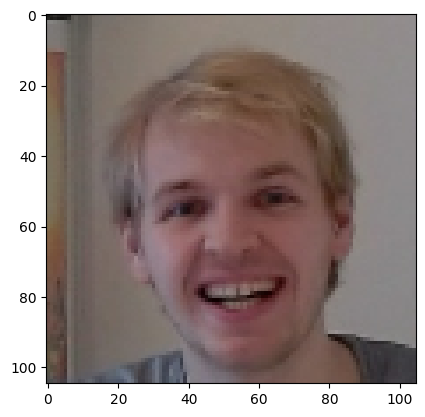

In [17]:
plt.imshow(img)

In [18]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [19]:
test_sample = data.as_numpy_iterator()

In [20]:
example = test_sample.next()
example

(b'data/anchor/80cb1dd4-c106-11ee-949d-9a60f45df4af.jpg',
 b'data/positive/1e0c4dfa-c109-11ee-bd9f-9a60f45df4af.jpg',
 1.0)

## Preprocess the data

In [21]:
def preprocess_twin(input_image, validation_image, label):
    return(preprocess(input_image), preprocess(validation_image), label)

In [22]:
res = preprocess_twin(*example)

In [23]:
# Dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

## Train test partitioning

In [24]:
# Training partitioning
train_data = data.take(round(len(data)*.7)) # 70% training data
train_data = train_data.batch(16)           # Ensuring same sample size
train_data = train_data.prefetch(8)         # Prepares next preprocessing

In [25]:
# Test partioning
test_data = data.skip(round(len(data)*.7))  # Skipping the train data
test_data = data.take(round(len(data)*.3))  # Retrieving test data (30%)
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Building neural network

## Embedding layer

In [26]:
inp = Input(shape=(105, 105, 3), name="input_image")
c1 = Conv2D(64, (10, 10), activation="relu")(inp)
max1 = MaxPooling2D(pool_size=(2, 2), padding="valid")(c1)
c2 = Conv2D(128, (7, 7), activation="relu")(max1)
m2 = MaxPooling2D(pool_size=(2, 2), padding="same")(c2)
 # Block 3
c3 = Conv2D(128, (4, 4), activation="relu")(m2)
m3 = MaxPooling2D(pool_size=(2, 2), padding="same")(c3)

    # Block 4 (Final layer)
c4 = Conv2D(256, (4, 4), activation="relu")(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation="sigmoid")(f1)

In [27]:
mod = Model(inputs=inp, outputs=d1, name="embedding")
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [28]:
def make_embedding():
    # Input layer
    inp = Input(shape=(105, 105, 3), name="input_image")
    # Block 1
    c1 = Conv2D(64, (10, 10), activation="relu")(inp)
    m1 = MaxPooling2D(pool_size=(2, 2), padding="same")(c1)

    # Block 2
    c2 = Conv2D(128, (7, 7), activation="relu")(m1)
    m2 = MaxPooling2D(pool_size=(2, 2), padding="same")(c2)

    # Block 3
    c3 = Conv2D(128, (4, 4), activation="relu")(m2)
    m3 = MaxPooling2D(pool_size=(2, 2), padding="same")(c3)

    # Block 4 (Final layer)
    c4 = Conv2D(256, (4, 4), activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)


    return Model(inputs=inp, outputs=d1, name="embedding")

In [29]:
embedding = make_embedding()

In [30]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 18, 128)       26

## Distance layer

In [31]:
# Siamese distance layer
class L1Dist(Layer):
    # Class init
    def __init__(self, **kwargs):
        super().__init__()
    
    # Distance calculation (Similarity)
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    

In [32]:
l1 = L1Dist()

In [34]:
# l1(anchor_embedding, validation_embedding)

## Combining the Siamese Network

In [35]:
def make_siamese_network():
    # Input
    input_image = Input(name="input_image", shape=(105, 105, 3))                # Anchor
    validation_image = Input(name="validation_image", shape=(105, 105, 3))      # Validation

    # Combine with siamese distance
    siamese_distance = L1Dist()
    siamese_distance._name = "distance"
    distances = siamese_distance(embedding(input_image), embedding(validation_image))

    # Final classification
    classifier = Dense(1, activation="sigmoid")(distances)

    # return the model
    return Model(inputs=[input_image, validation_image], outputs=classifier, name="SiameseNetwork")
    

In [36]:
siamese_model = make_siamese_network()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_image (InputLay  [(None, 105, 105, 3)]        0         []                            
 er)                                                                                              
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_image[0][0]',         
                                                          8          'validation_image[0][0]']    
                                                                                     

# Training

## Loss function and optimixer

In [37]:
bce = tf.losses.BinaryCrossentropy()

In [38]:
opt = tf.optimizers.legacy.Adam(learning_rate=1e-4)

## Training checkpoints

In [39]:
checkpoint_dir = "./training_checkpoints"
os.mkdir(checkpoint_dir) if not os.path.isdir(checkpoint_dir) else None
checkpoint_pfx = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=opt, siamese_model=siamese_model)

## Training step function (Batch training)

In [42]:
'''
    Input batch
    Make prediction
    Calculate error (loss)
    Gradient calculation
    Backpropogation
'''

# Decorator to make the training model outside compiled model
@tf.function 
# Function for batch training
def make_step(batch):
    # Watch over all operations
    with tf.GradientTape() as g:
        # Anchor and pos/neg images
        X = batch[:2]
        # Labels
        y_true = batch[2]

        # Prediction
        y_pred = siamese_model(X, training=True)
        # Binary cross entropy - loss
        loss = bce(y_true, y_pred)
    # Calculating gradients
    gradients = g.gradient(loss, siamese_model.trainable_variables)
    # Update weights and apply
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))
    # Return loss
    return loss


## Training loop

In [46]:
def train(parsed_data, epochs):
    for e in range(1, epochs+1):
        # Print the current epoch
        print(f"EPOCH: {e}/{epochs}\n")
        # Creating a progress bar (not necessary if wrapped in model class)
        progress_bar = tf.keras.utils.Progbar(target=len(parsed_data))

        # Loop through batch
        for idx, batch in enumerate(parsed_data):
            # Train step
            make_step(batch)
            progress_bar.update(idx+1)
        
        # Save checkpoints
        if e % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_pfx)

## Train model

In [47]:
epochs = 50

In [48]:
train(train_data, epochs)

EPOCH: 1/50

27/27 [==============================] - 18s 647ms/step
EPOCH: 2/50

27/27 [==============================] - 17s 628ms/step
EPOCH: 3/50

27/27 [==============================] - 16s 602ms/step
EPOCH: 4/50

27/27 [==============================] - 16s 597ms/step
EPOCH: 5/50

27/27 [==============================] - 16s 601ms/step
EPOCH: 6/50

27/27 [==============================] - 16s 604ms/step
EPOCH: 7/50

27/27 [==============================] - 16s 602ms/step
EPOCH: 8/50

27/27 [==============================] - 16s 601ms/step
EPOCH: 9/50

27/27 [==============================] - 16s 607ms/step
EPOCH: 10/50

27/27 [==============================] - 16s 604ms/step
EPOCH: 11/50

27/27 [==============================] - 17s 626ms/step
EPOCH: 12/50

27/27 [==============================] - 16s 606ms/step
EPOCH: 13/50

27/27 [==============================] - 16s 609ms/step
EPOCH: 14/50

27/27 [==============================] - 17s 611ms/step
EPOCH: 15/50

27/27 [========

# Model testing and evaluation

## Evaluation

In [54]:
# Import metric dependicies
from tensorflow.keras.metrics import Precision, Recall

In [68]:
# Batch of data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [69]:
# Making predicitions
y_pred = siamese_model.predict([test_input, test_val])
y_pred

1/1 [==============================] - 0s 287ms/step


array([[5.7911653e-09],
       [3.6128720e-06],
       [1.5557937e-08],
       [1.0000000e+00],
       [1.4410155e-07],
       [1.0000000e+00],
       [9.9999988e-01],
       [1.6716135e-09],
       [1.0000000e+00],
       [9.9997365e-01],
       [9.9996746e-01],
       [8.7216989e-10],
       [2.1991732e-04],
       [9.9986714e-01],
       [1.0596738e-10],
       [1.6869815e-07]], dtype=float32)

In [70]:
# Post processing
[1 if pred > 0.5 else 0 for pred in y_pred]

[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0]

In [71]:
y_true

array([0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.],
      dtype=float32)

## Evaluate model

In [75]:
# Recall metrics
m = Recall()
m.update_state(y_true, y_pred)
m.result().numpy()

1.0

In [76]:
# Precision metrics
p = Precision()
p.update_state(y_true, y_pred)
p.result().numpy()

1.0

## Results visualization

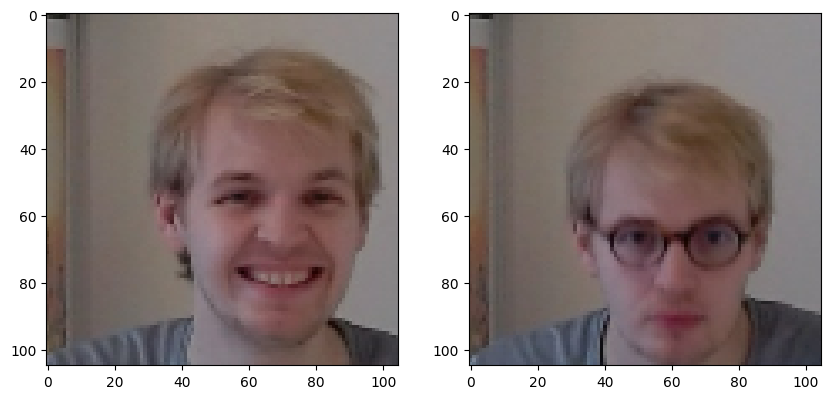

In [80]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(test_input[3])
plt.subplot(1, 2, 2)
plt.imshow(test_val[3])


# Saving the model

In [81]:
# Save the model weights
siamese_model.save("SiameseModel.h5")

/Users/mlc/miniconda3/envs/DeepFacialRecognition/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [82]:
# Reload the model
model = tf.keras.models.load_model("SiameseModel.h5",
                                   custom_objects={"L1Dist":L1Dist, "BinaryCrossentropy":tf.losses.BinaryCrossentropy})

In [85]:
# Reload prediction test
model.predict([test_input, test_val])

1/1 [==============================] - 0s 207ms/step


array([[5.7911653e-09],
       [3.6128720e-06],
       [1.5557937e-08],
       [1.0000000e+00],
       [1.4410155e-07],
       [1.0000000e+00],
       [9.9999988e-01],
       [1.6716135e-09],
       [1.0000000e+00],
       [9.9997365e-01],
       [9.9996746e-01],
       [8.7216989e-10],
       [2.1991732e-04],
       [9.9986714e-01],
       [1.0596738e-10],
       [1.6869815e-07]], dtype=float32)

In [86]:
# Model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_image (InputLay  [(None, 105, 105, 3)]        0         []                            
 er)                                                                                              
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_image[0][0]',         
                                                          8          'validation_image[0][0]']    
                                                                                     